Install all the required packages before running the Jupyter Notebook.

In [1]:
## Importing the Packages
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
%matplotlib inline


In [2]:
# Importing the data
df = pd.read_csv("ETH-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [3]:
df.shape

(1820, 7)

In [4]:
df.dropna(inplace=True)
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-29,1555.274658,1652.382202,1549.983643,1619.698486,1619.698486,21618154775
2022-10-30,1619.697876,1637.037842,1579.485229,1590.783325,1590.783325,13930073427
2022-10-31,1590.481323,1630.452881,1555.918945,1572.714478,1572.714478,19306919714
2022-11-01,1572.645386,1606.605713,1568.098511,1579.704590,1579.704590,14507311208
2022-11-02,1579.497925,1613.410645,1507.244751,1519.711792,1519.711792,23254218281


In [7]:
start_date = "2015-08-07"
mid_1 = "2020-12-20"
end_date = "2022-11-01"


<AxesSubplot:xlabel='Date'>

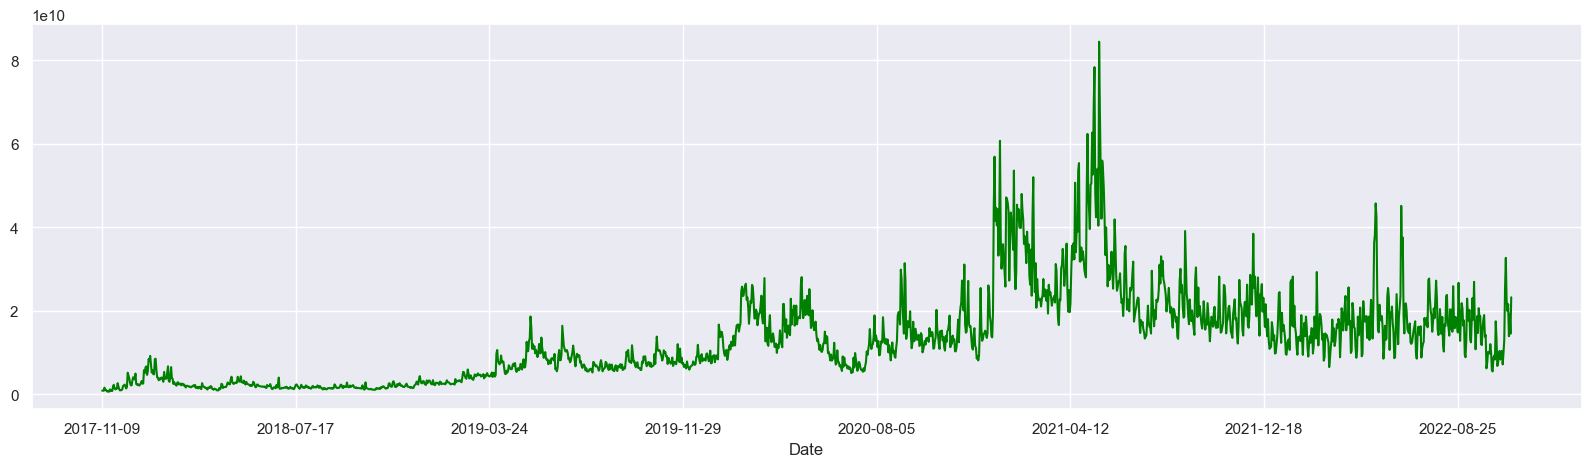

In [8]:
df["Volume"].plot(color = "green",figsize = (20,5))

<AxesSubplot:xlabel='Date'>

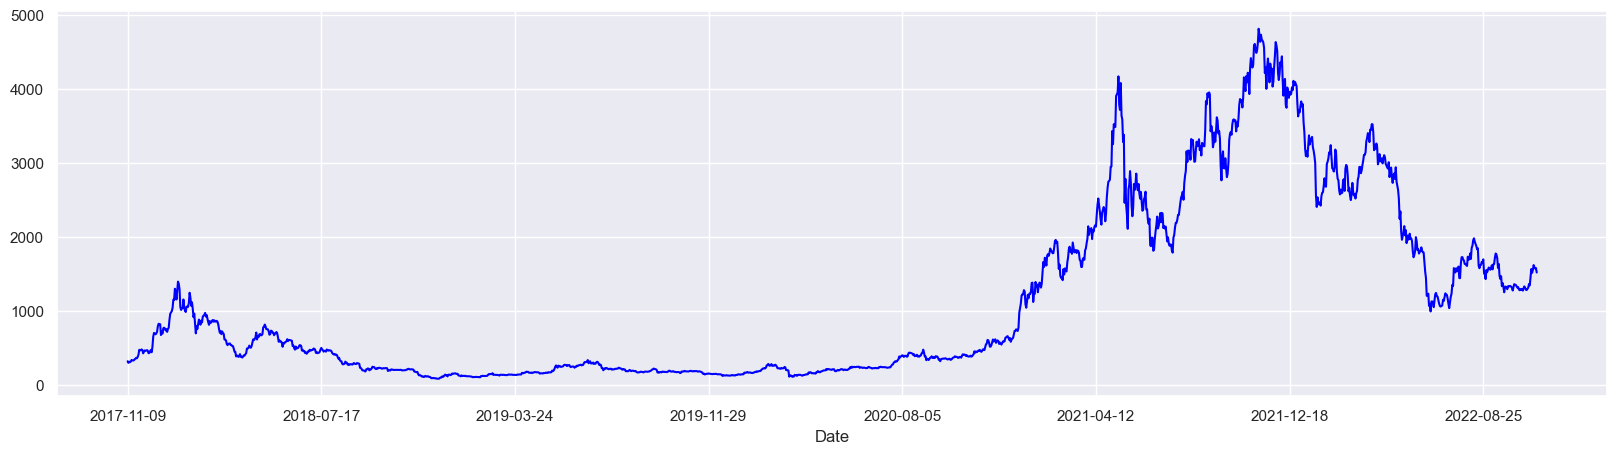

In [9]:
df["Close"].plot(color = "blue",figsize = (20,5))

## Closing Prices


### 1. AD Fuller Test for checking Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(x):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(x, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(df['Close'])



Results of Dickey-Fuller Test:
Test Statistic                   -1.369165
p-value                           0.596966
#Lags Used                       17.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [11]:
series = df['Close'].values
result = adfuller(series, autolag='AIC')
print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Stationary")

ADF Statistic: -1.369165
p-value: 0.596966
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Reject Ho - Time Series is Stationary


#### Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

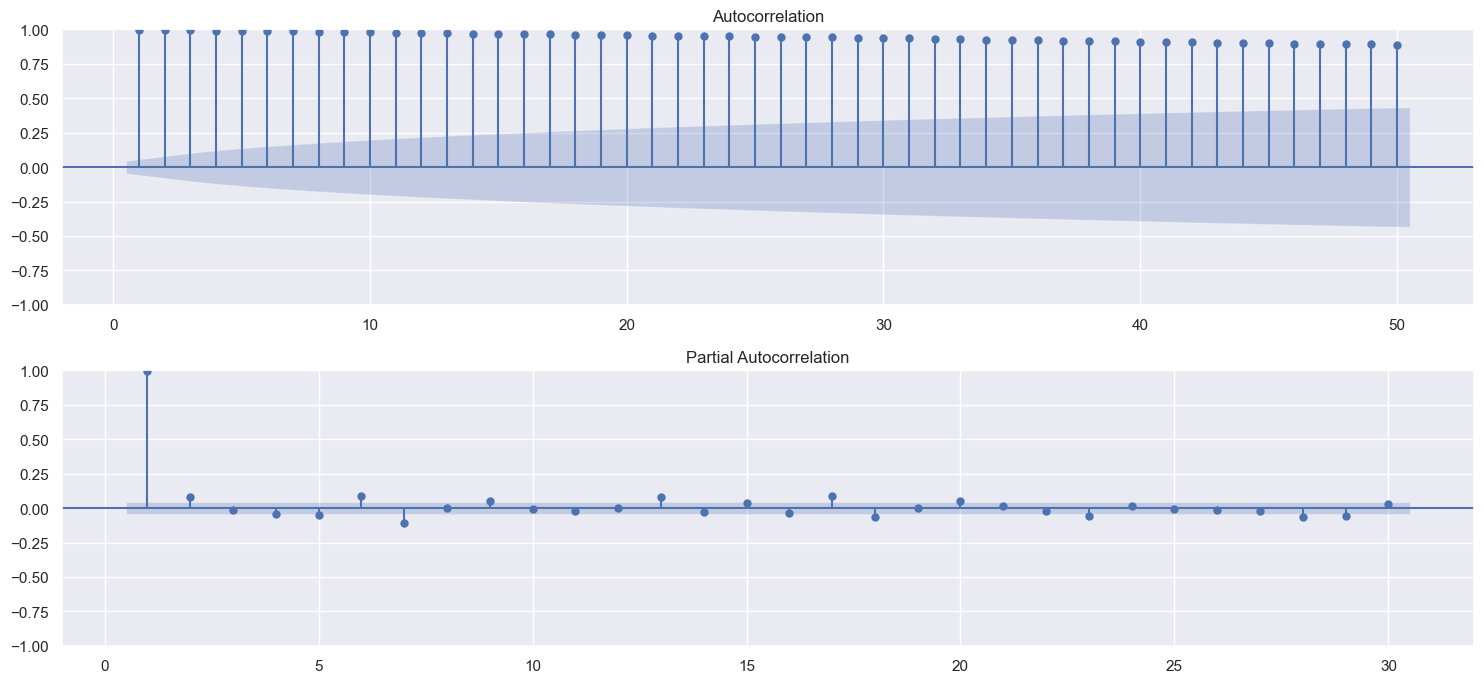

In [12]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Close[13:].values.squeeze(), lags=50, ax=ax,zero=False)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Close[13:].values.squeeze(), lags=30,zero=False
                          , ax=ax)
plt.tight_layout()
plt.show()

## Using ARIMA

In [13]:
#Using only Close
model_auto_pred_pr = auto_arima(df.Close[start_date:mid_1], exogenous = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']][start_date:mid_1],
                          m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5, trend = "ct")

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods = len(df[mid_1:end_date]),exogenous = df[['Open', 'High', 'Low','Adj Close', 'Volume']][mid_1:end_date]),
                               index = df[mid_1:end_date].index)



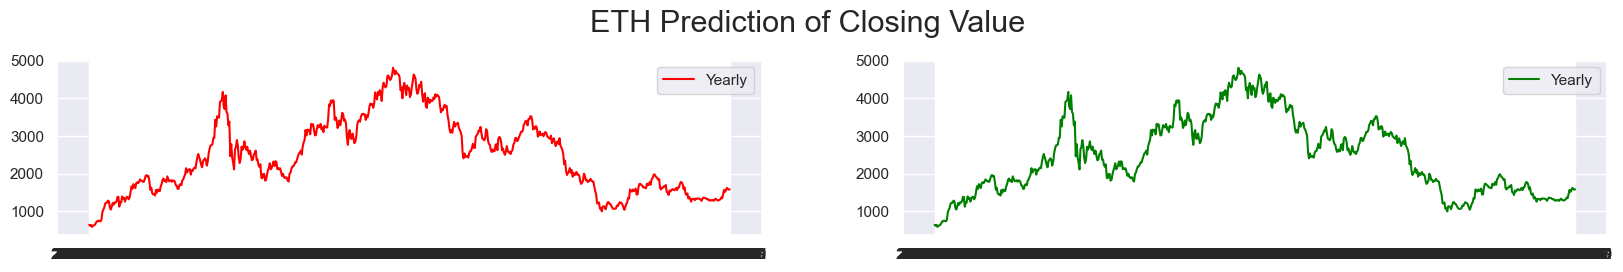

In [14]:
fig = plt.figure(figsize=[20, 5])
plt.suptitle("ETH Prediction of Closing Value", fontsize=22)

plt.subplot(221)
plt.plot(df_auto_pred_pr[mid_1:end_date], '-',color = "red",label = "Yearly")
plt.legend()

plt.subplot(222)
plt.plot(df.Close[mid_1:end_date], '-', color = "green",label = "Yearly")
plt.legend()

### This is OK

### Volatility trend for each time period

<AxesSubplot:xlabel='Date'>

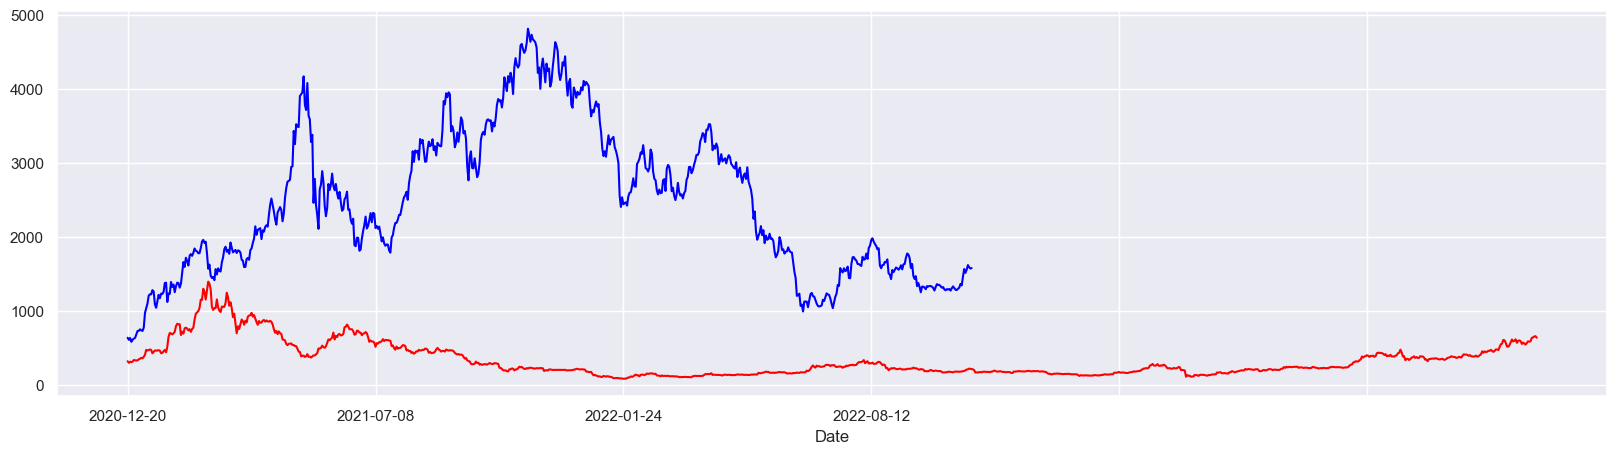

In [15]:
df.Close[start_date:mid_1].plot(figsize = (20,5),color = "red")
df.Close[mid_1:end_date].plot(color = "blue")

## Using Facebook Prophet

pip install pystan==2.19.1.1

pip install prophet

!pip install fbprophet

In [16]:
df_2 = pd.read_csv("ETH-USD.csv")
df_2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [17]:
df_2.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1.820000e+03
mean,1125.341185,1162.060633,1083.675060,1125.767445,1125.767445,1.301839e+10
std,1207.252207,1244.191200,1164.485527,1206.649176,1206.649176,1.085625e+10
min,84.279694,85.342743,82.829887,84.308296,84.308296,6.217330e+08
25%,208.688045,213.549805,203.371250,208.705383,208.705383,4.362559e+09
50%,471.581238,482.356110,457.637497,472.061721,472.061721,1.085669e+10
75%,1804.916565,1841.851746,1735.139252,1805.114319,1805.114319,1.833478e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


In [18]:
data = df_2[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
data.head()

,ds,y
0,2017-11-09,320.884003
1,2017-11-10,299.252991
2,2017-11-11,314.681000
3,2017-11-12,307.907990
4,2017-11-13,316.716003


In [19]:
data.dropna(inplace=True)

In [21]:
from prophet import Prophet
model = Prophet(daily_seasonality = True) 
model.fit(data)

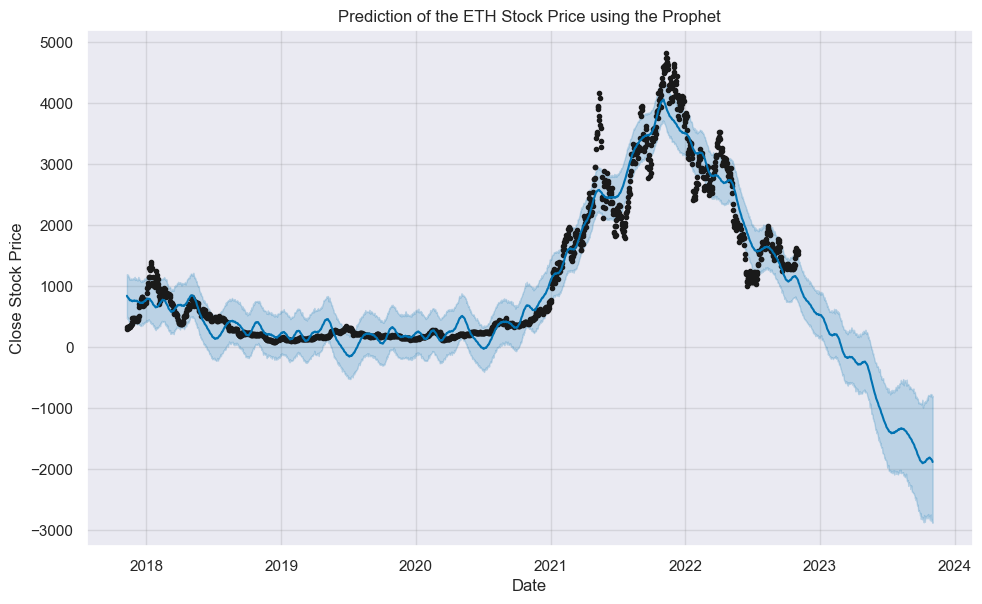

In [22]:
future = model.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = model.predict(future)
model.plot(prediction)
plt.title("Prediction of the ETH Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

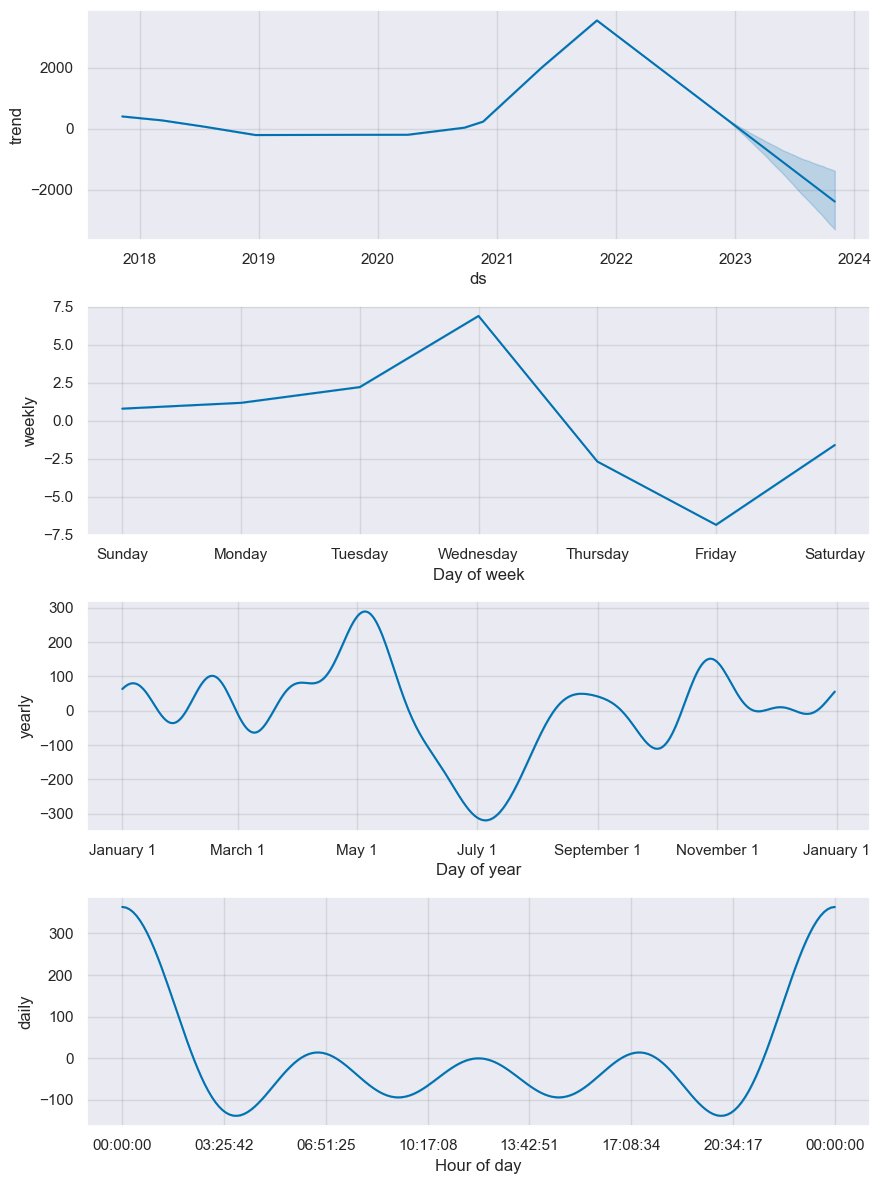

In [23]:
model.plot_components(prediction)
plt.show()